In [ ]:
%load_ext nb_black

# 0. Initiate

In [1]:
# Load packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy as sp
from scipy.io.wavfile import write
from tqdm import tqdm
import librosa
import librosa.display
import math

import warnings
warnings.simplefilter(action="ignore")

from HumBugDB.LogMelSpecs.compute_LogMelSpecs import waveform_to_examples
from DataProcessing.XGBoost_features.metadata import *
from DataProcessing.helper_code import *
from DataProcessing.find_and_load_patient_files import *
from DataProcessing.label_extraction import *

In [2]:
# Define paths
data_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/physionet.org/files/circor-heart-sound/1.0.3/training_data"
output_folder = "data/e_challenge_anaylsis/"

In [3]:
def get_features(data, recordings):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])
    recording_features = recording_features.flatten()

    features = np.hstack(([age_group], [age], sex_features, [height], [weight], [is_pregnant], recording_features))

    return np.asarray(features)

In [4]:
# Load recordings.
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    locations = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        locations.append(entries[0])
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, locations, frequencies
    else:
        return recordings, locations

# 1. Load data

In [5]:
 # Find the patient data files.
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)

murmur_classes = ['Present', 'Unknown', 'Absent']
num_murmur_classes = len(murmur_classes)
outcome_classes = ['Abnormal', 'Normal']
num_outcome_classes = len(outcome_classes)
features = list()
murmurs = list()
outcomes = list()
recordings = list()
locations = list()
print("Extracting features from patient data...")
for i in tqdm(range(num_patient_files)):

    # Load the current patient data and recordings.
    current_patient_data = load_patient_data(patient_files[i])
    current_recordings, current_locations = load_recordings(data_folder, current_patient_data)
    current_recordings = [r / 32768 for r in current_recordings]
    num_recordings_code = get_num_locations(current_patient_data)
    num_recordings = len(current_recordings)
    recordings.append(current_recordings)
    locations.append(current_locations)

    # Extract features.
    current_features = get_features(current_patient_data, current_recordings)
    current_features = np.insert(current_features,0,current_patient_data.split(" ")[0])
    current_features = np.insert(current_features,1,current_patient_data.split(" ")[2][:-3])
    current_features = np.insert(current_features,2,num_recordings)
    current_features = np.insert(current_features,3,num_recordings_code)
    features.append(current_features)

    # Extract labels and use one-hot encoding.
    ## Murmur
    current_murmur = np.zeros(num_murmur_classes, dtype=int)
    murmur = get_murmur(current_patient_data)
    if murmur in murmur_classes:
        j = murmur_classes.index(murmur)
        current_murmur[j] = 1
    murmurs.append(current_murmur)
    ## Outcome
    current_outcome = np.zeros(num_outcome_classes, dtype=int)
    outcome = get_outcome(current_patient_data)
    if outcome in outcome_classes:
        j = outcome_classes.index(outcome)
        current_outcome[j] = 1
    outcomes.append(current_outcome)

features = np.vstack(features)
murmurs = np.vstack(murmurs)
outcomes = np.vstack(outcomes)

# Combine dataframes
print("Combining dataframes...")
assert len(recordings) == len(locations)
features_pd = pd.DataFrame(features, columns=["id", "hz", "num_recordings", "num_recordings_code", "age_group", "age", "female", "male", "height", "weight", "is_pregnant"]+[f"standard_recording_features_{i}_{t}" for t in ["1", "mean", "var", "skew"] for i in range(5)])#+[f"signatures{i}" for i in range(len(features[0])-12)])
murmurs_pd = pd.DataFrame(murmurs, columns=murmur_classes)
outcomes_pd = pd.DataFrame(outcomes, columns=outcome_classes)
recordings_pd = pd.DataFrame(columns=np.unique([item for sublist in locations for item in sublist]))
for i in tqdm(range(len(locations))):
    dict_data = {locations[i][j]: [recordings[i][j]] for j in range(len(locations[i]))}
    temp_df = pd.DataFrame(dict_data)
    recordings_pd = pd.concat([recordings_pd, temp_df], ignore_index=True)
complete_pd = pd.concat([features_pd.loc[:, [c for c in features_pd.columns if "standard_recording_features_" not in c]], murmurs_pd, outcomes_pd, recordings_pd], axis=1)

# Prep
features_pd["age_year"] = features_pd['age'].astype(float).astype(int, errors='ignore')/12
complete_pd["age_year"] = complete_pd['age'].astype(float).astype(int, errors='ignore')/12
complete_pd["murmur"]= [1 if p==1 else -1 if a==1 else 0 for p,a  in zip(complete_pd.Present, complete_pd.Absent)]
complete_pd["is_pregnant"] = complete_pd["is_pregnant"].apply(lambda x: 0 if x=="False" else 1)

# Get recordings length
for c in complete_pd.columns:
    if "location" in c and "length" not in c:
        complete_pd[c].loc[complete_pd[c].isnull()] = complete_pd[c].loc[complete_pd[c].isnull()].apply(lambda x: [])
        complete_pd[f"length_sec_{c}"] = complete_pd[c].apply(len)/complete_pd['hz'].astype(float).astype("Int64")

# Label nans correctly
complete_pd = complete_pd.replace("nan", np.nan)

# Convert columns
complete_pd["age"] = complete_pd["age"].astype(float)
complete_pd["height"] = complete_pd["height"].astype(float)
complete_pd["weight"] = complete_pd["weight"].astype(float)
complete_pd["age_year"] = complete_pd["age_year"].astype(float)
complete_pd["age_group"] = complete_pd["age_group"].fillna("Unknown")

Extracting features from patient data...


100%|██████████| 942/942 [00:03<00:00, 274.36it/s]


Combining dataframes...


100%|██████████| 942/942 [00:00<00:00, 3098.61it/s]


In [6]:
# Save df
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
complete_pd[['id', 'hz', 'num_recordings', 'num_recordings_code', 'age_group', 'age', 'female',
       'male', 'height', 'weight', 'is_pregnant', 'Present', 'Unknown',
       'Absent', 'Abnormal', 'Normal', 'age_year',
       'murmur']].to_csv(f"{output_folder}complete_pd.csv", index=False)

# 2. Data distributions

In [7]:
# Descriptive
pd.DataFrame(complete_pd.describe())

,age,height,weight,is_pregnant,Present,Unknown,Absent,Abnormal,Normal,age_year,murmur
count,868.000000,826.000000,837.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,868.000000,942.000000
mean,70.883641,110.800242,23.632756,0.074310,0.190021,0.072187,0.737792,0.484076,0.515924,5.906970,-0.547771
std,40.445269,30.000607,15.453337,0.262414,0.392526,0.258934,0.440069,0.500012,0.500012,3.370439,0.792734
min,0.500000,35.000000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,-1.000000
25%,72.000000,89.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-1.000000
50%,72.000000,115.000000,20.400000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,6.000000,-1.000000
75%,72.000000,133.000000,31.200000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,6.000000,0.000000
max,180.000000,180.000000,110.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


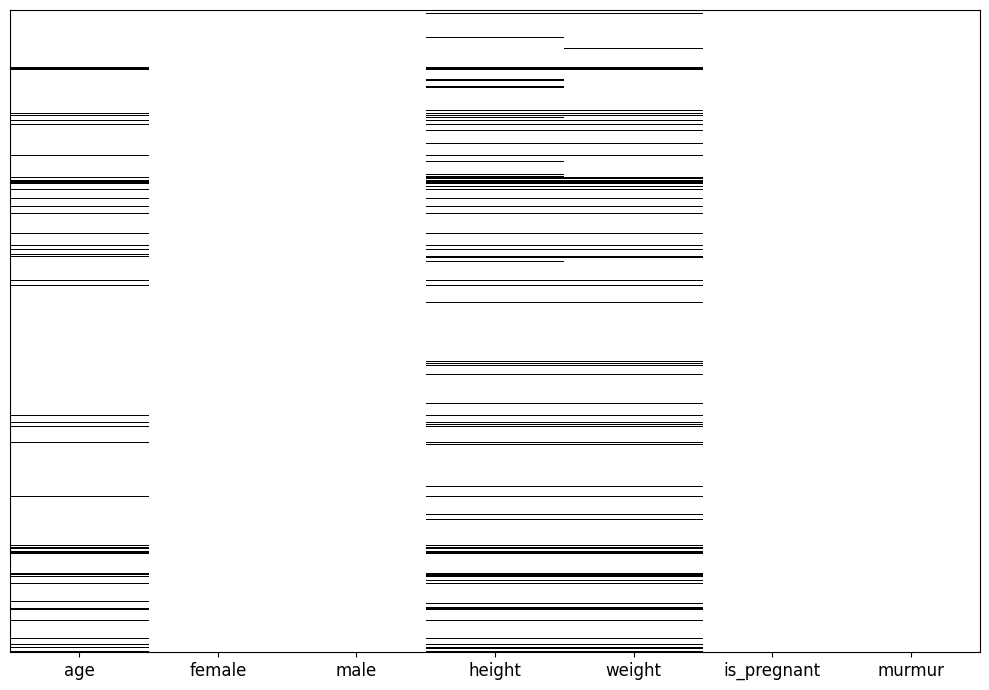

In [8]:
# Missing values
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(complete_pd[['age', 'female', 'male', 'height', 'weight', 'is_pregnant', 'murmur']].astype(float).isna(), cbar=False, cmap="Greys", ax=ax)
plt.xticks(fontsize=12, rotation=0)
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)

# Save
fig.tight_layout()
fig.savefig(os.path.join(output_folder, "missing_values.pdf"), format='pdf')

<Axes: >

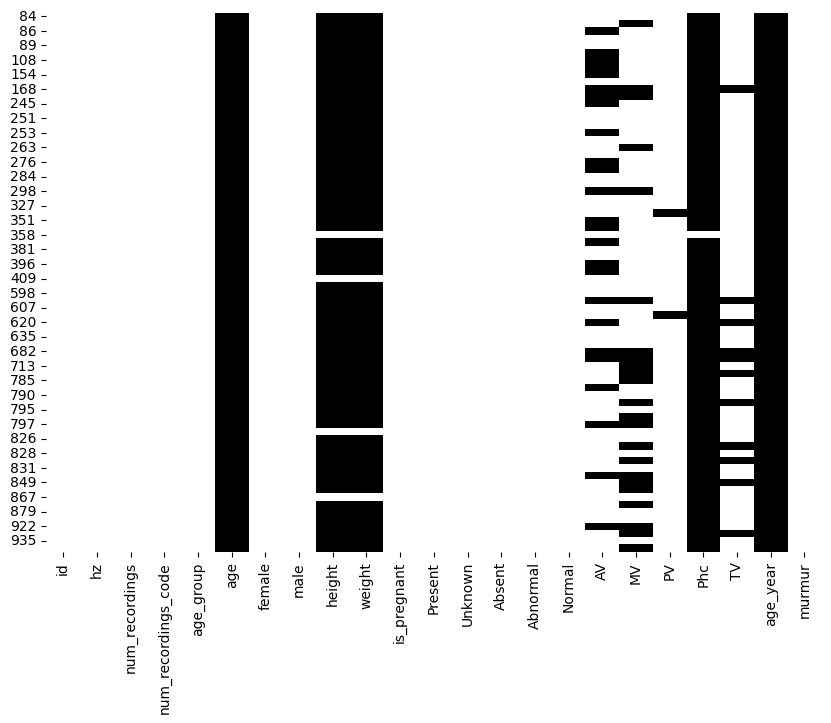

In [9]:
# Missing values if age is missing
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(complete_pd.loc[complete_pd.age.isnull(),:].isnull(), cbar=False, cmap="Greys", ax=ax)

<Axes: xlabel='weight', ylabel='Count'>

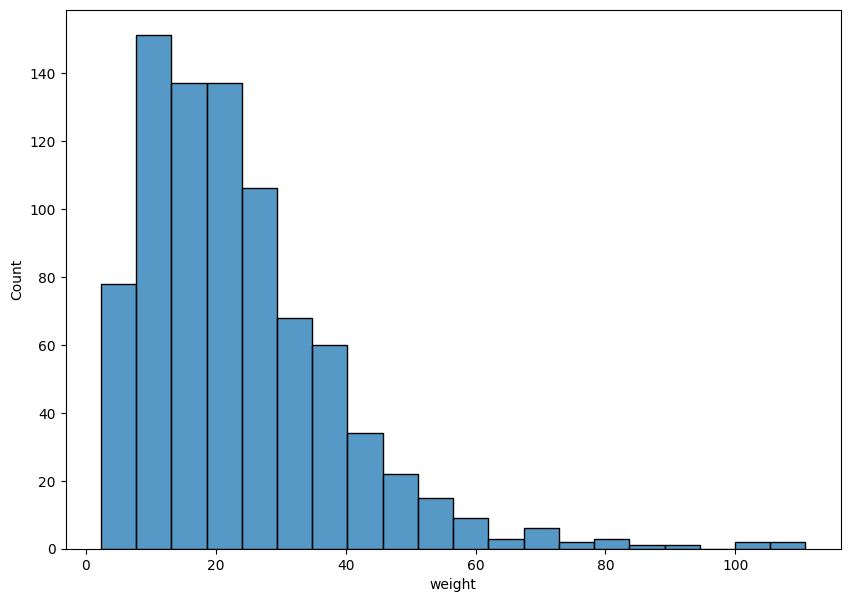

In [10]:
# Weight
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(complete_pd.weight.astype(float), bins=20)

<Axes: xlabel='height', ylabel='Count'>

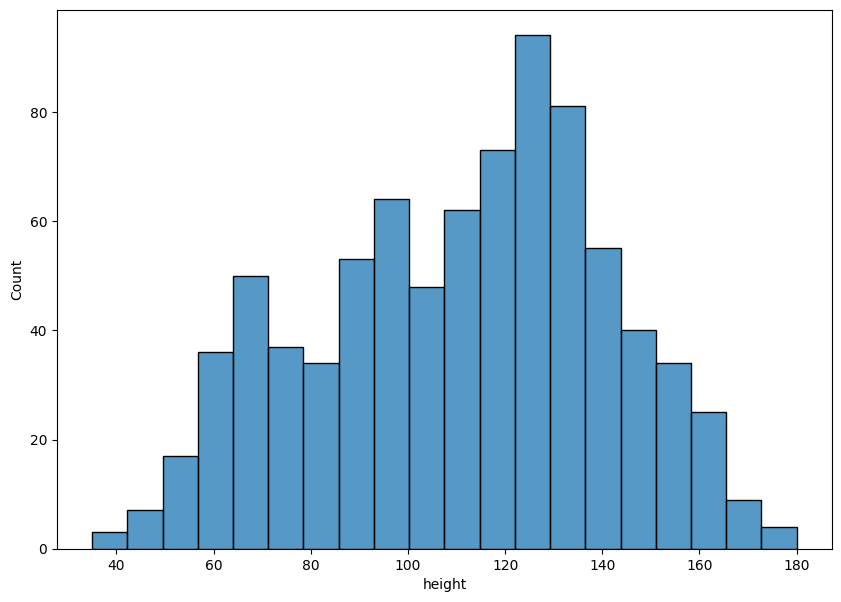

In [11]:
# Height
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(complete_pd["height"].astype(float), bins=20)

In [12]:
complete_pd["age_group"].unique()

array(['Child', 'Adolescent', 'Infant', 'Unknown', 'Neonate'],
      dtype=object)

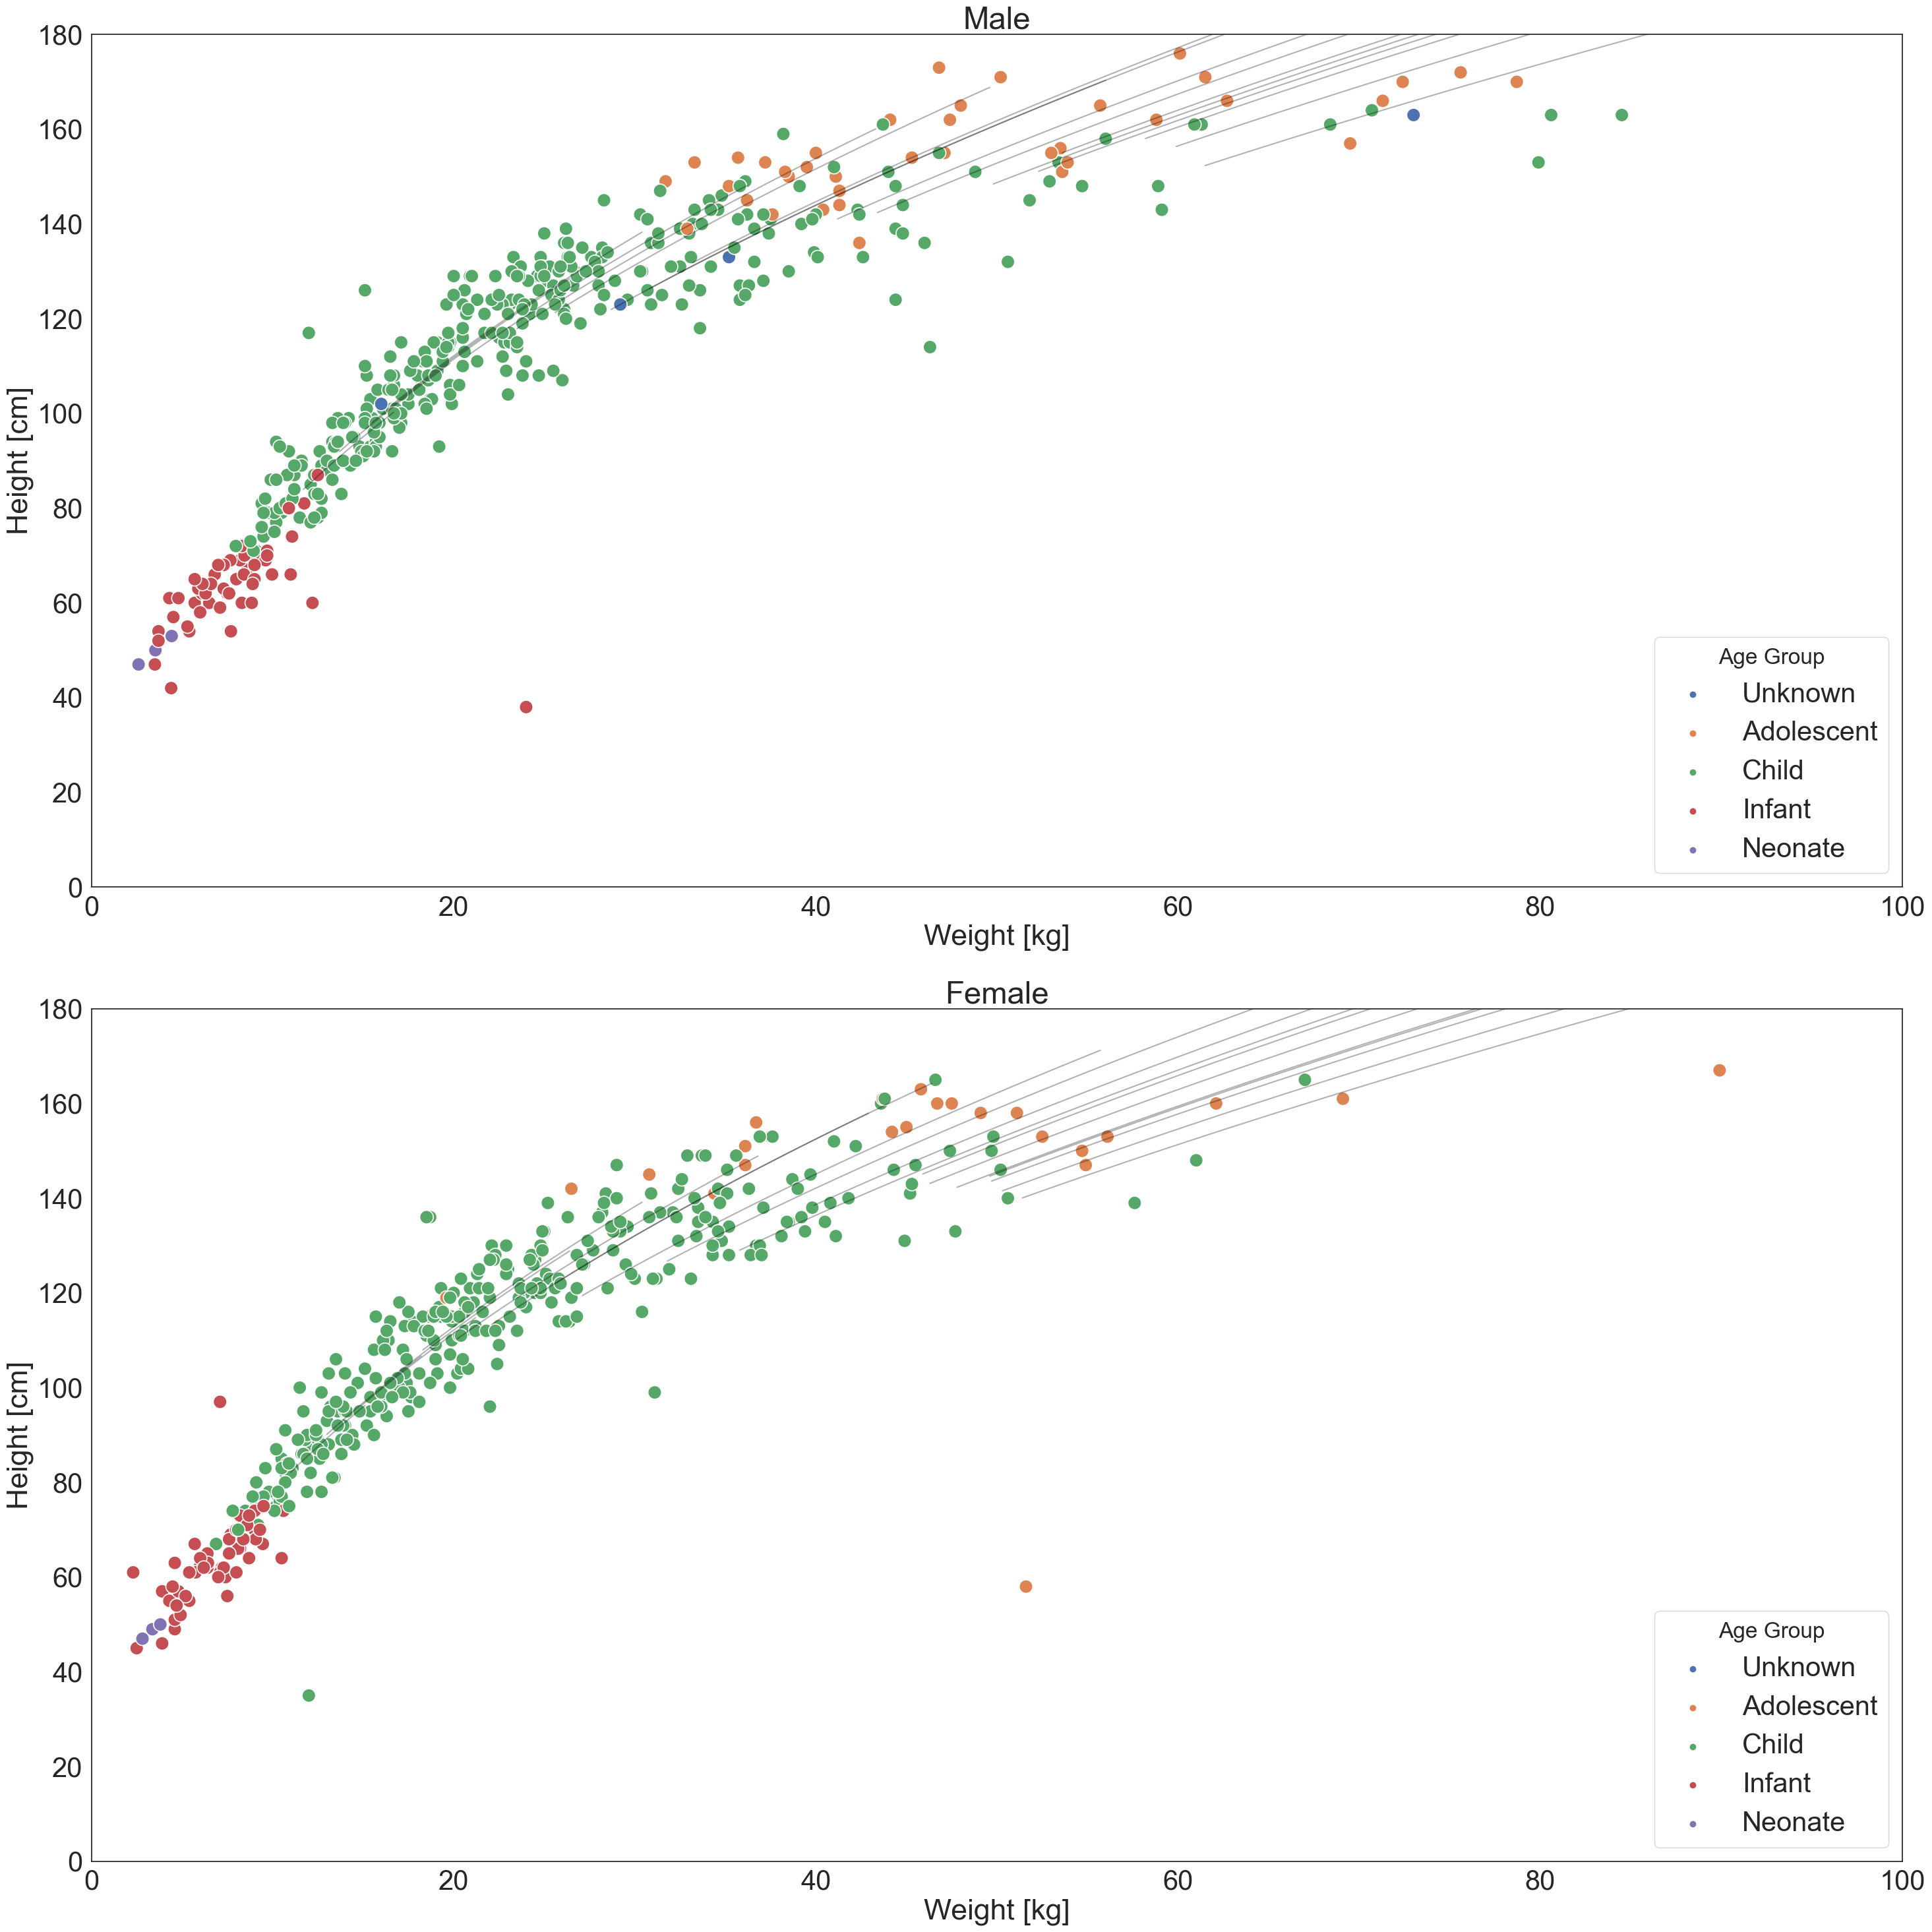

In [71]:
# BMI values
bmi_male = {2: 16.6, 3: 16.2, 4: 16.1, 5: 16.0, 6: 15.9, 7: 16.5, 8: 16.9, 9: 17.4, 10: 19.3, 11: 19.3, 12: 19.1, 13: 20.7, 14: 21.4, 15: 22.6, 16: 22.3, 17: 22.9, 18: 23.3, 19: 24.5, 20: 26.5}
bmi_female = {2: 16.3, 3: 16.0, 4: 16.1, 5: 15.9, 6: 15.7, 7: 16.6, 8: 17.2, 9: 17.2, 10: 19.0, 11: 19.8, 12: 21.5, 13: 20.8, 14: 22.6, 15: 21.8, 16: 23.7, 17: 24.1, 18: 23.6, 19: 25.1, 20: 26.2}
weight_male = {2: (11.7,16.7), 3: (13.7,19.8), 4: (15.5,22.3), 5: (16.6,26.4), 6: (18.8,30.4), 7: (20.9,36.2), 8: (23.5,43.3), 9: (25.6,49.6), 10: (28.7,56), 11: (30.8,64.2), 12: (33.2,67.9), 13: (41.2,87.3), 14: (43.4,91.1), 15: (49.8,104.7), 16: (53.6,90.2), 17: (52.3,103.7), 18: (58.2,101.4), 19: (59.9,104.2), 20: (61.5,116)}
weight_female = {2: (11,15.1), 3: (13,18.2), 4: (14.9,21.2), 5: (16.2,26.4), 6: (18.3,30.4), 7: (20.2,36.8), 8: (22.1,42.9), 9: (25.6,46.4), 10: (27.1,55.7), 11: (31.8,66.6), 12: (35.8,70.6), 13: (39.9,78.2), 14: (46.3,80.9), 15: (45.9,85.4), 16: (49.6,85.2), 17: (49.7,90.1), 18: (47.8,96.2), 19: (50.3,95.7), 20: (51.4,107)}

# Set global font size
global_font_size = 30

# Define axis limits
x_limits = [0, 100]  # Replace with actual limits
y_limits = [0, 180]  # Replace with actual limits

# Create 1 row and 2 columns for subplots
fig, axes = plt.subplots(2, 1, figsize=(30, 30))

# Common settings
sns.set(font_scale=2.0)
sns.set_style("white")
plt.rcParams['font.size'] = global_font_size

# Plot for male (male == 1)
male_data = complete_pd[complete_pd['male'] == "1"]
sns.scatterplot(x="weight", y="height", hue="age_group", data=male_data, hue_order=['Unknown', 'Adolescent', 'Child', 'Infant', 'Neonate'], s=220, ax=axes[0])
axes[0].set_title('Male', fontsize=global_font_size+4)
axes[0].set(xlabel='Weight [kg]', ylabel='Height [cm]')
axes[0].set_xlabel('Weight [kg]', fontsize=global_font_size+2)
axes[0].set_ylabel('Height [cm]', fontsize=global_font_size+2)
axes[0].set_xlim(x_limits)
axes[0].set_ylim(y_limits)
axes[0].tick_params(axis='both', which='major', labelsize=global_font_size)
axes[0].legend().set_title('Age Group', prop={'size': global_font_size})
axes[0].legend(loc='lower right', fontsize=global_font_size, title='Age Group')
for a in bmi_male.keys():
    bmi = bmi_male[a]
    weight_list = np.linspace(weight_male[a][0], weight_male[a][1], 50)
    height_list = [100*(w/bmi)**0.5 for w in weight_list]
    axes[0].plot(weight_list, height_list, color='black', alpha=0.3)

# Plot for female (male == 0)
female_data = complete_pd[complete_pd['male'] == "0"]
sns.scatterplot(x="weight", y="height", hue="age_group", data=female_data, hue_order=['Unknown', 'Adolescent', 'Child', 'Infant', 'Neonate'], s=220, ax=axes[1])
axes[1].set_title('Female', fontsize=global_font_size+4)
axes[1].set(xlabel='Weight [kg]', ylabel='Height [cm]')
axes[1].set_xlabel('Weight [kg]', fontsize=global_font_size+2)
axes[1].set_ylabel('Height [cm]', fontsize=global_font_size+2)
axes[1].set_xlim(x_limits)
axes[1].set_ylim(y_limits)
axes[1].tick_params(axis='both', which='major', labelsize=global_font_size)
axes[1].legend().set_title('Age Group', prop={'size': global_font_size})
axes[1].legend(loc='lower right', fontsize=global_font_size, title='Age Group')
for a in bmi_male.keys():
    bmi = bmi_female[a]
    weight_list = np.linspace(weight_female[a][0], weight_female[a][1], 50)
    height_list = [100*(w/bmi)**0.5 for w in weight_list]
    axes[1].plot(weight_list, height_list, color='black', alpha=0.3)

# Save the figure
fig.tight_layout()
plt.savefig(os.path.join(output_folder, 'age_weight_height_by_gender.pdf'), format='pdf')

# Show the plot
plt.show()


In [17]:
# Labels
pd.crosstab([complete_pd.Abnormal, complete_pd.Normal], [complete_pd.Present, complete_pd.Unknown, complete_pd.Absent, complete_pd.murmur])

Present            0        1
Unknown            0   1    0
Absent             1   0    0
murmur            -1   0    1
Abnormal Normal              
0        1       432  25   29
1        0       263  43  150

# 3. Recordings

In [72]:
location_names = ["AV", "MV", "PV", "Phc", "TV"]
dic_aux = {}
for l in location_names:
    dic_aux[l] = [0 if isinstance(v, float) else len(v)/4000 for v in complete_pd[l]]
df_lengths = pd.DataFrame({"length_sec": [item for sublist in dic_aux.values() for item in sublist], "murmur": list(complete_pd.murmur)*len(location_names)})
df_lengths["length_sec"] = df_lengths["length_sec"].astype(float)

<Axes: xlabel='length_sec', ylabel='Count'>

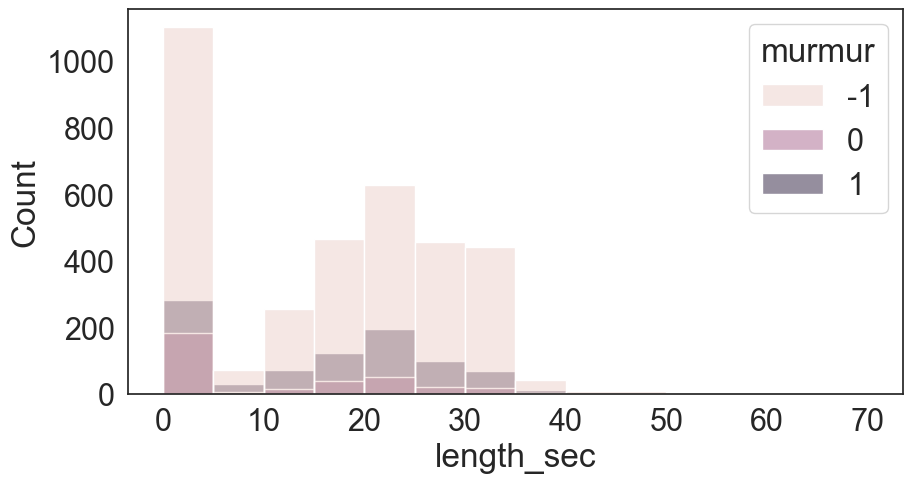

In [73]:
# Length
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.histplot(df_lengths, x="length_sec", hue="murmur", ax=ax, stat="count", bins=[0,5,10,15,20,25,30,35,40,50,60,70])

<Axes: xlabel='num_recordings', ylabel='Count'>

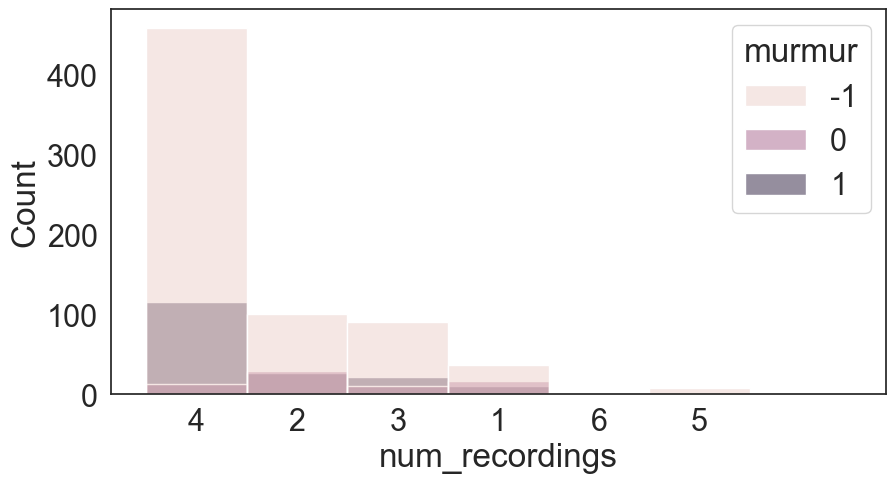

In [74]:
# Num recordings
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.histplot(complete_pd, x="num_recordings", hue="murmur", ax=ax, stat="count", binrange=[0,6], binwidth=1)

# 4. Pascal data

In [ ]:
# Define folders
normal_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Training B Normal"
murmur_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Btraining_murmur"
extrastole_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Btraining_extrastole/"
output_folder = "data/e_challenge_anaylsis/"

In [ ]:
# Get all paths
normal_paths = [os.path.join(normal_folder, f) for f in os.listdir(normal_folder) if ".wav" in f]
murmur_paths = [os.path.join(murmur_folder, f) for f in os.listdir(murmur_folder) if ".wav" in f]
extrastole_paths = [os.path.join(extrastole_folder, f) for f in os.listdir(extrastole_folder) if ".wav" in f]

In [ ]:
# Combine in dataframe
df_pascal = pd.DataFrame({"path": normal_paths + murmur_paths + extrastole_paths, "label": ["normal"]*len(normal_paths) + ["murmur"]*len(murmur_paths) + ["extrastole"]*len(extrastole_paths)})
df_pascal["rec_length"] = np.nan
df_pascal["frequency"] = np.nan
df_pascal["rec_duration_sec"] = np.nan
df_pascal["recording"] = np.nan
df_pascal["recording"] = df_pascal["recording"].astype(object)
for i in range(len(df_pascal)):
    recording, frequency = load_wav_file(df_pascal.path.iloc[i])
    df_pascal["rec_length"].iloc[i] = len(recording)
    df_pascal["frequency"].iloc[i] = frequency
    df_pascal["rec_duration_sec"].iloc[i] = len(recording)/frequency
    df_pascal["recording"].iloc[i] = recording

# Save df
df_pascal.to_csv(f"{output_folder_pascal}df_pascal.csv", index=False)

In [ ]:
df_pascal.head(2)

In [ ]:
# Distribution of labels
pd.crosstab([df_pascal.label], [df_pascal.label])

In [ ]:
# Length
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['font.size'] = 15
sns.histplot(df_pascal, x="rec_duration_sec", hue="label", ax=ax, stat="count", bins=[0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25])
ax.set(xlabel='Recording duration [sec]')

In [ ]:
df_pascal[df_pascal.label=="extrastole"].rec_duration_sec.describe()

In [ ]:
print(np.max([np.max(i) for i in df_pascal.recording]))
print(np.min([np.min(i) for i in df_pascal.recording]))

# 5. 2016 Challenge

In [75]:
# Initiate if not already done
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from DataProcessing.helper_code import *

In [76]:
# Define folders
annotation_file = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pyc2016/annotations/annotations.csv"
data_dir = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pyc2016/"
output_folder = "data/e_challenge_anaylsis/"

In [77]:
# Load data
pd_annotations = pd.read_csv(annotation_file)
all_recordings = [os.path.join(data_dir, f) for f in pd_annotations.path_rel]
pd_annotations["path"] = all_recordings
metadata_recordings = [f for f in pd_annotations[pd_annotations["Height (cm)"]>0]["path"]]
pd_annotations["metadata_flag"] = [1 if f in metadata_recordings else 0 for f in all_recordings]
print(f"Number of recordings: {len(all_recordings)}")
print(f"Number of recordings with metadata: {len(metadata_recordings)}")

Number of recordings: 3153
Number of recordings with metadata: 31


In [78]:
# Load recordings
pd_annotations["rec_length"] = np.nan
pd_annotations["frequency"] = np.nan
pd_annotations["rec_duration_sec"] = np.nan
pd_annotations["recording"] = np.nan
pd_annotations["recording"] = pd_annotations["recording"].astype(object)
for i in range(len(pd_annotations)):
    recording, frequency = load_wav_file(pd_annotations["path"].iloc[i])
    pd_annotations.at[i, "rec_length"] = len(recording)
    pd_annotations.at[i, "frequency"] = frequency
    pd_annotations.at[i, "rec_duration_sec"] = len(recording)/frequency
    pd_annotations.at[i, "recording"] = recording

# Normalise recordings
pd_annotations["recording"] = [i/32768 for i in pd_annotations.recording]

# Save df
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
pd_annotations.to_csv(os.path.join(output_folder, "2016_challenge_annotations.csv"), index=False)

In [79]:
# Recording stats
pd_annotations["rec_duration_sec"].describe()

count    3153.000000
mean       22.525783
std        12.454862
min         5.305500
25%        12.837000
50%        20.898000
75%        30.650500
max       121.998500
Name: rec_duration_sec, dtype: float64

In [80]:
pd_annotations[pd_annotations["rec_duration_sec"]>100]["rec_duration_sec"].describe()

count      4.000000
mean     107.672750
std        9.811318
min      100.970000
25%      101.497250
50%      103.861250
75%      110.036750
max      121.998500
Name: rec_duration_sec, dtype: float64

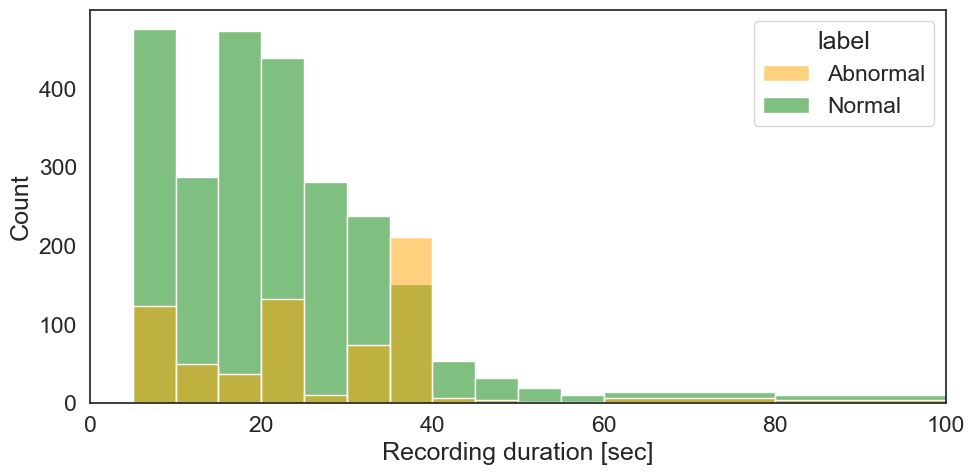

In [106]:
# Plot
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['font.size'] = 15
sns.histplot(pd_annotations, x="rec_duration_sec", hue="label", ax=ax, stat="count", bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140], palette={"Abnormal": "orange", "Normal": "green"})
ax.set(xlabel='Recording duration [sec]')
ax.set_xlim([0, 100])

# Save
fig.tight_layout()
fig.savefig(os.path.join(output_folder, "2016_length.pdf"), format='pdf')


In [ ]:
# T-Test
# Separate the rec_duration_sec data based on label values
group1 = pd_annotations[pd_annotations['label'] == 'Abnormal']['rec_duration_sec']
group2 = pd_annotations[pd_annotations['label'] == 'Normal']['rec_duration_sec']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

print(f"Number of abnormal recordings: {len(group1)}")
print(f"Number of normal recordings: {len(group2)}")
print(f"Average recording duration for abnormal recordings: {round(np.mean(group1),4)} sec")
print(f"Average recording duration for normal recordings: {round(np.mean(group2),4)} sec")
print("T statistic:", round(t_statistic,4))
print("P value:", p_value)

In [ ]:
# Compare recordings
print("Training set:")
print(np.min(complete_pd["MV"][0]))
print(np.mean(complete_pd["MV"][0]))
print(np.max(complete_pd["MV"][0]))
print("Test set:")
print(np.min(pd_annotations["recording"][0]))
print(np.mean(pd_annotations["recording"][0]))
print(np.max(pd_annotations["recording"][0]))

In [ ]:
# plot both recordings, complete_pd["MV"][0] and pd_annotations["recording"][0]
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 15
sns.lineplot(data=complete_pd["MV"][0], ax=ax, color="blue")
sns.lineplot(data=pd_annotations["recording"][0], ax=ax, color="red")
ax.set(xlabel='Time [sec]', ylabel='Amplitude')
ax.legend(["Training set", "Test set"])